In [1]:
# -*- encoding: utf-8 -*-
'''
@File        :__init__.py
@Time        :2021/03/30 17:00:33
@Author      :wlgls
@Version     :1.0a
'''

from sklearn.neighbors import KDTree
import numpy as np

class Relief(object):
    """This is the code implementation of relief, It is modified from https://github.com/gitter-badger/ReliefF/.

    Relief algorithm is a kind of feature weighting algorithms, which gives different weights to each feature according to the correlation of each feature and category. Then the feature is selected according to the weight

    Parameters
    ----------
    m_samples int: , optional
        In the relief algorithm, we need to sample from the training samples many times, and it's the number of samples. If it's None, It's X.shape[0]. by default None
    n_features_to_keep : int, optional
        The number of features you keep. If it's None, It's X.shape[2]//2.  by default None
    feature_scores: 1d-array
        The weight of the feature.
    feature_sort: 1d-array
        Index of features descending sorted by score, 

    Examples
    ---------
    """
    def __init__(self, m_samples=None, n_features_to_keep=None):
        
        self.m_samples = m_samples
        self.n_features_to_keep =n_features_to_keep
        self.feature_scores = None
        self.feature_sort = None

    def fit(self, X, y):
        """Learn the features to select.

        Parameters
        ----------
        X : array-like
            Training vectors
        y : array-like
            Target values

        Return
        ----------
        self: object
        """

        if self.m_samples is None:
            self.m_samples = X.shape[0]
        if self.n_features_to_keep is None:
            self.n_features_to_keep = X.shape[1] // 2

        self.feature_scores = np.zeros(X.shape[1])
        
        # binary classification problem
        l1, l2 = np.unique(y)[0], np.unique(y)[1]
        l1X = X[y==l1]
        l2X = X[y==l2]
        l1Tree = KDTree(l1X)
        l2Tree = KDTree(l2X)

        for source_ind in np.random.choice(X.shape[0], size=self.m_samples, replace=False):
            
            # In order to eliminate the interference of the same elements, k = 2 is selected
            _, l1ind = l1Tree.query(X[source_ind].reshape(1, -1), k=2)
            _, l2ind = l2Tree.query(X[source_ind].reshape(1, -1), k=2)

            # del the same elements
            if np.any(X[source_ind] == l1X[l1ind[0, 0]]):
                l1ind = l1ind[0, 1]
                l2ind = l2ind[0, 0]
            else:
                l1ind = l1ind[0, 0]
                l2ind = l2ind[0, 1]

            # Weight update
            if y[source_ind] == l1:
                # It means l1ind is hit
                self.feature_scores = self.feature_scores - l1X[l1ind]/self.m_samples + l2X[l2ind]/self.m_samples
            if y[source_ind] == l2:
                # It means l2ind is hit
                self.feature_scores = self.feature_scores + l1X[l1ind]/self.m_samples - l2X[l2ind]/self.m_samples
            
        self.feature_sort = np.argsort(self.feature_scores)[::-1]

        return self

    def transform(self, X):
        """select features

        Parameters
        ----------
        X : array-like
            Test vectors

        Return
        ----------
        X_reduced: array-like
            Selected features
        """
        return X[:, self.feature_sort[:self.n_features_to_keep]]

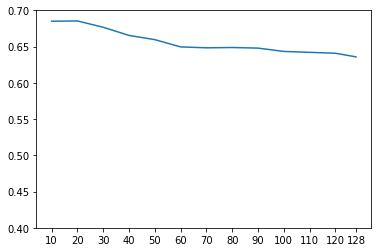

In [2]:
## 整体代码
# 这些包就是上一个代码里面的那些函数，我只是封装起来了
from pyeeg.load_data import load_deap
from pyeeg.features_extraction import power_spectral_density
from pyeeg.feature_process import combined_electrode, group_by_trial
from pyeeg.preprocessing import remove_baseline, split_signal, label_binarizer

from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneGroupOut

from matplotlib import pyplot as plt

# 读数据， 选用前32个通道，第一个标签
path = "/home/wlgls/Desktop/DEAP/data_preprocessed_python"
data, label = load_deap(path, 0)

# 标签二值化
label = label_binarizer(label)

### 将8064 63s的数据按照一秒的窗口分割
d, l =split_signal(data, label)

# 将数据分为基线和实际观影信号，前3秒就是基线
base, baselabel, signalx, signallabel = remove_baseline(d, l)

# 求解特征
basef = power_spectral_density(base)# 基线
signalf = power_spectral_density(signalx) # 信号

# 将他们按照通道推起来
basef = combined_electrode(basef)
signalf = combined_electrode(signalf)

# 减去基线 对基线求平均后减掉
base_mean = np.mean(basef, axis=1)[:, np.newaxis, :]
psdf = signalf - base_mean
psdY = signallabel

# 对数据分组, 就是说一个试验60s,分成60个片段，但是最后属于这个试验
G, X, Y = group_by_trial(psdf, psdY)

cv = LeaveOneGroupOut()
svc = SVC(C=0.01)

refscore = []
n_rests = []

# 保留特征数
for n_rest in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 128]:
    ref = Relief(n_features_to_keep=n_rest)
    cvscore = []
    for index_train, index_test in cv.split(X=X, groups=G):
        X_train, Y_train = X[index_train], Y[index_train]
        X_test, Y_test = X[index_test], Y[index_test]
        
        # 训练relief
        ref.fit(X_train, Y_train)
        X_train = ref.transform(X_train)
        X_test = ref.transform(X_test)
        
        svc.fit(X_train, Y_train)
        s = svc.score(X_test, Y_test)
        cvscore.append(s)
    n_rests.append(n_rest)
    refscore.append(np.mean(cvscore))

plt.plot(n_rests, refscore)
plt.ylim(0.4, 0.7)
plt.xticks(n_rests)
plt.show()

In [23]:
n_rests

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 128]

In [4]:
# 这些包就是上一个代码里面的那些函数，我只是封装起来了
from pyeeg.load_data import load_deap
from pyeeg.features_extraction import power_spectral_density
from pyeeg.feature_process import combined_electrode, group_by_trial
from pyeeg.preprocessing import remove_baseline, split_signal, label_binarizer

In [5]:
# 读数据， 选用前32个通道，第一个标签
path = "/home/wlgls/Desktop/DEAP/data_preprocessed_python"
data, label = load_deap(path, 0)
data.shape, label.shape

((40, 32, 8064), (40, 1))

In [6]:
# 标签二值化
label = label_binarizer(label)
np.unique(label)

array([0., 1.])

In [7]:
### 将8064 63s的数据按照一秒的窗口分割
d, l =split_signal(data, label)
d.shape, l.shape

((40, 63, 32, 128), (40, 63))

In [8]:
# 将数据分为基线和实际观影信号，前3秒就是基线
base, baselabel, signalx, signallabel = remove_baseline(d, l)
base.shape, baselabel.shape, signalx.shape, signallabel.shape

((40, 3, 32, 128), (40, 3), (40, 60, 32, 128), (40, 60))

In [9]:
# 求解特征
basef = power_spectral_density(base)# 基线
signalf = power_spectral_density(signalx) # 信号
basef.shape, signalf.shape # 每个通道提出来4个频道功率

((40, 3, 32, 4), (40, 60, 32, 4))

In [10]:
# 将他们按照通道推起来
basef = combined_electrode(basef)
signalf = combined_electrode(signalf)
basef.shape, signalf.shape

((40, 3, 128), (40, 60, 128))

In [11]:
# 减去基线 对基线求平均后减掉
base_mean = np.mean(basef, axis=1)[:, np.newaxis, :]
psdf = signalf - base_mean
psdY = signallabel
psdf.shape, psdY.shape

((40, 60, 128), (40, 60))

In [12]:
# 对数据分组, 就是说一个试验60s,分成60个片段，但是最后属于这个试验
G, X, Y = group_by_trial(psdf, psdY)
G.shape, X.shape, Y.shape

((2400,), (2400, 128), (2400,))

In [13]:
G[:120]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [14]:
print(np.any(X[:60] == psdf[0]))
print(np.any(X[60:120]== psdf[1]))
print(np.any(X[60*8:60*9] == psdf[8]))

print(np.any(Y[:60] == psdY[0]))
print(np.any(Y[60:120] == psdY[1]))
print(np.any(Y[60*8:60*9] == psdY[8]))

True
True
True
True
True
True


In [15]:
# 在正常实验中，我一般采用留一法

In [16]:
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneGroupOut

In [17]:
cv = LeaveOneGroupOut()
svc = SVC(C=0.01)


In [18]:
refscore = []
n_rests = []
for n_rest in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 128]:
    ref = Relief(n_features_to_keep=n_rest)
    cvscore = []
    for index_train, index_test in cv.split(X=X, groups=G):
        X_train, Y_train = X[index_train], Y[index_train]
        X_test, Y_test = X[index_test], Y[index_test]
        
        # 训练relief
        ref.fit(X_train, Y_train)
        X_train = ref.transform(X_train)
        X_test = ref.transform(X_test)
        
        svc.fit(X_train, Y_train)
        s = svc.score(X_test, Y_test)
        cvscore.append(s)
    n_rests.append(n_rest)
    refscore.append(np.mean(cvscore))

In [19]:
n_rests

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 128]

In [20]:
refscore

[0.6849999999999999,
 0.6854166666666667,
 0.6766666666666666,
 0.6654166666666667,
 0.6595833333333333,
 0.6495833333333334,
 0.6483333333333332,
 0.6487499999999999,
 0.6479166666666666,
 0.6433333333333333,
 0.6420833333333335,
 0.6408333333333334,
 0.6358333333333334]

In [21]:
from matplotlib import pyplot as plt

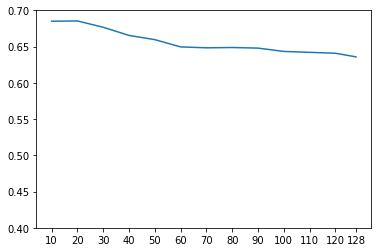

In [22]:
plt.plot(n_rests, refscore)
plt.ylim(0.4, 0.7)
plt.xticks(n_rests)
plt.show()